In [1]:
# %load svd.py
import numpy as np
from PIL import Image
import os
from glob import glob
from torchvision import transforms

join = os.path.join
listdir = os.listdir
splitext = os.path.splitext
imgs_dir = "/home/sj/workspace/m/MA_NET/LITS/train/raw/"
ids = [splitext(file)[0] for file in listdir(imgs_dir) if not file.startswith('.')]
img_m = np.zeros([512, 512])

# img_m.shape
postfix = ids[0]
img_file = glob(imgs_dir + postfix + '.*')
img = Image.open(img_file[0])
# img.show()
img_nd = np.array(img)
img_trans = img_nd/255
transform = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Normalize((-1.5,), (1.0,))
            transforms.Normalize((0.5,), (0.5,))
        ])
# transform(img_trans).float()
# print(img_trans)
# U, s, V = np.linalg.svd(img_trans)
# print('U: {}'.format(U))
# print('s: {}'.format(s))
# print('V: {}'.format(V))


volume-61.nii (193, 512, 512) -98


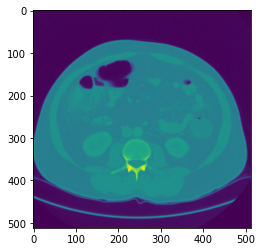

In [12]:
import numpy as np
import os
import glob
import SimpleITK as sitk
from scipy import ndimage
import matplotlib.pyplot as plt  # 载入需要的库

# 指定数据root路径，其中data目录下是volume数据，label下是segmentation数据，都是.nii格式
data_path = r'/home/sj/workspace/data/LITS-Challenge-Train-Data/data'
label_path = r'/home/sj/workspace/data/LITS-Challenge-Train-Data/label'  

dataname_list = os.listdir(data_path)

pattern = re.compile(r'\d+')
dataname_list.sort(key=lambda filenames: int(pattern.findall(filenames)[-1]))

# print(dataname_list)
ori_data = sitk.ReadImage(os.path.join(data_path,dataname_list[61])) # 读取其中一个volume数据
data1 = sitk.GetArrayFromImage(ori_data) # 提取数据中心的array
print(dataname_list[61],data1.shape,data1[61,255,255]) #打印数据name、shape和某一个元素的值

plt.imshow(data1[100,:,:]) # 对第100张slice可视化
plt.show()

In [ ]:
slices = [dicom.read_file(os.path.join(folder_name,filename)) for filename in os.listdir(folder_name)] 
slices = np.stack([s.pixel_array for s in slices])

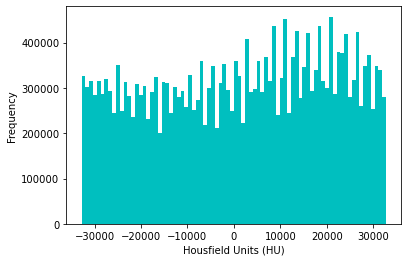

TypeError: can only concatenate list (not "MultiValue") to list

In [19]:
# %load ./dataset/load_dcm.py
import glob
import os
import SimpleITK as sitk
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O(e.g. pd.read_csv)
import pydicom
from scipy import ndimage as ndi
from matplotlib import pyplot as plt

"""Hounsfield Unit = pixel_value * rescale_slope + rescale_intercept"""
join = os.path.join


def load_scan(path):
    slices = [pydicom.read_file(join(path, s)) for s in os.listdir(path)]
    # slices is sorted by ImagePositionPatient
    slices.sort(key=lambda x: int(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices


def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16)
    # Should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    for slice_number in range(len(slices)):
        intercept = slices[slice_number].RescaleIntercept  # Intercept
        slope = slices[slice_number].RescaleIntercept
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
        image[slice_number] += np.int16(intercept)
    return np.array(image, dtype=np.int16)


def resample(image, scan, new_spaceing=[1, 1, 1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array(list(spacing))
    resize_factor = spacing / new_spaceing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)  # 返回浮点数x的四舍五入值。
    real_resize_factor = new_shape / image.shape
    new_spaceing = spacing / real_resize_factor
    image = ndi.interpolation.zoom(image, real_resize_factor, mode='nearest')
    return image, new_spaceing


MIN_BOUND = -1000.0
MAX_BOUND = 400.0


def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image > 1] = 1.
    image[image < 0] = 0.
    return image





path = "/home/sj/workspace/data/chao_data/Train_Sets/CT/1/DICOM_anon/"
first_patient = load_scan(path)
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Housfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
def plot_3d(image, threshold=-300):
    # Position the scan upright,
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)  #将扫描件竖直放置
    verts, faces = measure.marching_cubes(p, threshold) #Liner推进立方体算法来查找3D体积数据中的曲面。
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)  #创建3Dpoly
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)  #设置颜色
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    plt.show()
# 调用函数
plot_3d(pix_resampled, 400)